In [22]:
import pandas as pd

In [23]:
validation_sentences_file = "../data/validation-english/sentences.tsv"
validation_labels_file = "../data/validation-english/labels-cat.tsv"
predictions_file = "../approaches/presence/output/Text-predictions.tsv"

# Step 1: Load the Data

In [24]:
# Load the data files
sentences_df = pd.read_csv(validation_sentences_file, sep="\t")
labels_df = pd.read_csv(validation_labels_file, sep="\t")
predictions_df = pd.read_csv(predictions_file, sep="\t")

# Display the first few rows of each
print(sentences_df.head())
print(labels_df.head())
print(predictions_df.head())

  Text-ID  Sentence-ID                                               Text
0  EN_003            1                                                 PM
1  EN_003            2    Orban: Gradual reopening may begin after Easter
2  EN_003            3  The faster we vaccinate, the sooner the number...
3  EN_003            4  This is why it is important not to be deceived...
4  EN_003            5  The prime minister said he expects that the nu...
  Text-ID  Sentence-ID  Self-direction: thought attained  \
0  BG_005            1                               0.0   
1  BG_005            2                               0.0   
2  BG_005            3                               0.0   
3  BG_005            4                               0.0   
4  BG_005            5                               0.0   

   Self-direction: thought constrained  Self-direction: action attained  \
0                                  0.0                              0.0   
1                                  0.0       

# Step 2: Merge the Data

In [25]:
# Merge datasets on 'Text-ID' and 'Sentence-ID'
merged_df = sentences_df.merge(labels_df[['Text-ID', 'Sentence-ID', 'Presence']], on=['Text-ID', 'Sentence-ID'])
merged_df = merged_df.merge(predictions_df[['Text-ID', 'Sentence-ID', 'Presence']], on=['Text-ID', 'Sentence-ID'], suffixes=('_true', '_pred'))

# Convert predictions to binary (threshold of 0.5)
merged_df['Presence_pred_binary'] = merged_df['Presence_pred'].apply(lambda x: 1 if x >= 0.5 else 0)

# Add a column for misclassification
merged_df['Misclassified'] = merged_df['Presence_true'] != merged_df['Presence_pred_binary']

# View misclassified samples
misclassified_df = merged_df[merged_df['Misclassified']]
print(misclassified_df[['Text-ID', 'Sentence-ID', 'Text', 'Presence_true', 'Presence_pred', 'Presence_pred_binary']])


        Text-ID  Sentence-ID  \
4        EN_003            5   
7        EN_003            8   
8        EN_003            9   
12       EN_003           13   
13       EN_003           14   
...         ...          ...   
14889  TR_M_024            3   
14890  TR_M_024            4   
14899  TR_M_024           13   
14900  TR_M_024           14   
14902  TR_M_024           16   

                                                    Text  Presence_true  \
4      The prime minister said he expects that the nu...            1.0   
7      There is only one remedy that can help us slow...            0.0   
8      Many have suffered serious losses and find it ...            1.0   
12     Shops, factories or hotels cannot be reopened ...            0.0   
13     Parents need to know when they can take their ...            0.0   
...                                                  ...            ...   
14889  Investments envisaging the utilization of new ...            0.0   
14890  Having n

# Step 3: Identify False Positives and False Negatives

In [26]:
# False Positives: Model predicted presence (1), but ground truth is 0
false_positives = misclassified_df[(misclassified_df['Presence_pred_binary'] == 1) & (misclassified_df['Presence_true'] == 0)]
print("False Positives:")
print(false_positives[['Text-ID', 'Sentence-ID', 'Text', 'Presence_pred']])

# False Negatives: Model predicted absence (0), but ground truth is 1
false_negatives = misclassified_df[(misclassified_df['Presence_pred_binary'] == 0) & (misclassified_df['Presence_true'] == 1)]
print("False Negatives:")
print(false_negatives[['Text-ID', 'Sentence-ID', 'Text', 'Presence_pred']])


False Positives:
        Text-ID  Sentence-ID  \
7        EN_003            8   
12       EN_003           13   
13       EN_003           14   
18       EN_003           19   
19       EN_003           20   
...         ...          ...   
14889  TR_M_024            3   
14890  TR_M_024            4   
14899  TR_M_024           13   
14900  TR_M_024           14   
14902  TR_M_024           16   

                                                    Text  Presence_pred  
7      There is only one remedy that can help us slow...       0.948382  
12     Shops, factories or hotels cannot be reopened ...       0.502843  
13     Parents need to know when they can take their ...       0.599262  
18     I think those in the medical sector must conti...       0.968155  
19     The government took into account the unions' r...       0.970935  
...                                                  ...            ...  
14889  Investments envisaging the utilization of new ...       0.928396  
14890 

# Step 4: Analyze Word Patterns in Misclassified Sentences

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Collect misclassified text samples
misclassified_sentences = misclassified_df['Text'].tolist()

# Convert text to lowercase and remove stopwords
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(misclassified_sentences)

# Get word frequencies
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_sums = word_counts.sum().sort_values(ascending=False)

print("Most common words in misclassified sentences:")
print(word_sums.head(20))


Most common words in misclassified sentences:
said          426
new           252
people        237
government    201
time          193
year          188
minister      180
years         174
president     169
according     162
country       159
european      155
eu            137
support       135
state         131
work          131
energy        123
percent       121
countries     114
national      108
dtype: int64


In [28]:
from collections import Counter

def analyze_misclassified(data, misclass_type):
    # Filter for false positives or negatives
    if misclass_type == 'FP':
        filtered_data = data[(data['Presence_true'] == 0) & (data['Presence_pred'] == 1)]
    elif misclass_type == 'FN':
        filtered_data = data[(data['Presence_true'] == 1) & (data['Presence_pred'] == 0)]
    
    # Tokenize and count word frequencies
    word_counter = Counter(" ".join(filtered_data['Text']).split())
    return word_counter.most_common(20)  # Top 20 words

false_positive_words = analyze_misclassified(merged_df, 'FP')
false_negative_words = analyze_misclassified(merged_df, 'FN')
print("Frequent words in false positives:", false_positive_words)
print("Frequent words in false negatives:", false_negative_words)


Frequent words in false positives: []
Frequent words in false negatives: []


# Step 5: Check Overfitting to Certain Phrases

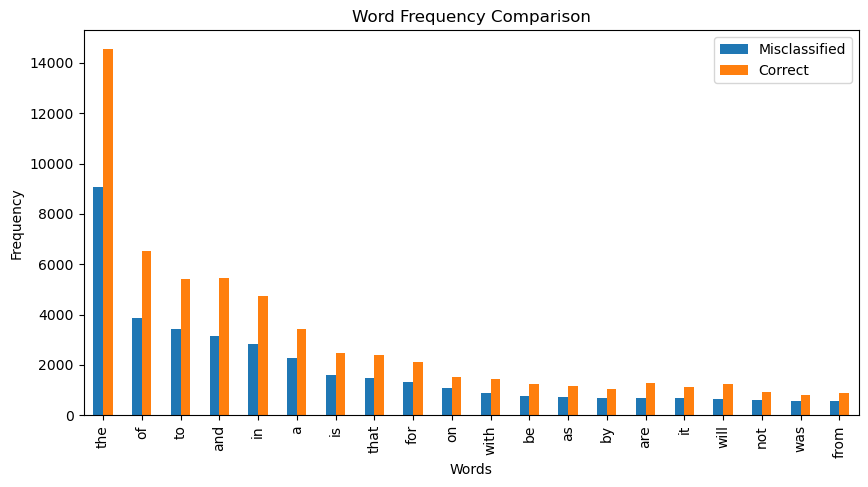

In [29]:
# Tokenize text and count occurrences of each word
import matplotlib.pyplot as plt

def count_word_occurrences(df, column):
    all_text = " ".join(df[column].tolist()).lower().split()
    word_freq = pd.Series(all_text).value_counts()
    return word_freq

# Compare word frequencies in misclassified vs correct sentences
misclassified_word_freq = count_word_occurrences(misclassified_df, 'Text')
correct_word_freq = count_word_occurrences(merged_df[~merged_df['Misclassified']], 'Text')

# Plot comparison for top words
common_words = misclassified_word_freq.index.intersection(correct_word_freq.index)
comparison_df = pd.DataFrame({'Misclassified': misclassified_word_freq[common_words], 
                              'Correct': correct_word_freq[common_words]})

comparison_df[:20].plot(kind='bar', figsize=(10,5))
plt.title("Word Frequency Comparison")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


# Step 6: Investigate Context Dependence

Look at sentences where the same words appear but are classified differently.

Check surrounding context to see if specific phrases influence predictions.

In [30]:
word_of_interest = 'support'  # Change this to test different words

# Find sentences containing the word
contains_word = merged_df[merged_df['Text'].str.contains(word_of_interest, case=False, na=False)]

# Count total occurrences of the word
total_sentences_with_word = len(contains_word)

# Count misclassified occurrences of the word
misclassified_sentences_with_word = contains_word['Misclassified'].sum()

# Calculate percentage of misclassified sentences
if total_sentences_with_word > 0:
    misclassification_percentage = (misclassified_sentences_with_word / total_sentences_with_word) * 100
else:
    misclassification_percentage = 0

# Display results
print(f"Total sentences containing '{word_of_interest}': {total_sentences_with_word}")
print(f"Misclassified sentences containing '{word_of_interest}': {misclassified_sentences_with_word}")
print(f"Percentage misclassified: {misclassification_percentage:.2f}%")


Total sentences containing 'support': 398
Misclassified sentences containing 'support': 173
Percentage misclassified: 43.47%


# Step 6-bis: Calculate the misclassification percentage for every word

In [31]:
import pandas as pd
import re
from collections import Counter

# Load the merged dataframe (assuming it contains 'Text', 'Presence_true', 'Presence_pred', 'Misclassified')
# merged_df = pd.read_csv('your_merged_file.csv')

# Function to tokenize sentences into words (simple splitting, can be improved with NLP libraries)
def tokenize_text(text):
    return re.findall(r'\b\w+\b', text.lower())

# Tokenize all sentences
merged_df['tokenized_words'] = merged_df['Text'].apply(tokenize_text)

# Count occurrences of each word in the entire dataset
all_words = [word for sublist in merged_df['tokenized_words'] for word in sublist]
word_counts = Counter(all_words)

# Count occurrences of each word in misclassified sentences
misclassified_words = merged_df[merged_df['Misclassified']]['tokenized_words']
misclassified_words_flat = [word for sublist in misclassified_words for word in sublist]
misclassified_counts = Counter(misclassified_words_flat)

# Calculate misclassification percentage for each word
word_misclassification_stats = {
    word: {
        'total_occurrences': word_counts[word],
        'misclassified_occurrences': misclassified_counts[word],
        'misclassification_percentage': (misclassified_counts[word] / word_counts[word]) * 100 if word_counts[word] > 0 else 0
    }
    for word in word_counts
}

# Convert the results to a dataframe
misclassification_df = pd.DataFrame.from_dict(word_misclassification_stats, orient='index')
misclassification_df.reset_index(inplace=True)
misclassification_df.rename(columns={'index': 'Word'}, inplace=True)

# Sort by misclassification percentage in descending order
misclassification_df = misclassification_df.sort_values(by='misclassification_percentage', ascending=False)

# Display top misclassified words
print("Words with highest misclassification percentage:")
print(misclassification_df.head(20))  # Show the top 20 misclassified words

# Save results to a CSV file for further analysis
misclassification_df.to_csv('misclassification_analysis.csv', index=False)
print("Results saved to 'misclassification_analysis.csv'.")


Words with highest misclassification percentage:
                        Word  total_occurrences  misclassified_occurrences  \
20327            gendarmerie                  1                          1   
20317                grameen                  1                          1   
20318           microfinance                  1                          1   
20319                   tgmp                  1                          1   
20301                 poetry                  1                          1   
20302                  epics                  1                          1   
20292                  bosom                  2                          2   
20324                 tomato                  1                          1   
20323              tailoring                  1                          1   
20274                    433                  1                          1   
20256              vacancies                  1                          1   
20259          

## Analyze Misclassifications

Identify Frequent Words and Phrases in Misclassified Sentences:

Extract the sentences that are false positives and false negatives.

Tokenize these sentences and count word/phrase frequencies.

Compare these word/phrase distributions to correctly classified sentences to spot patterns.

In [34]:
from collections import Counter

def analyze_misclassified(data, misclass_type):
    # Filter for false positives or negatives
    if misclass_type == 'FP':
        filtered_data = data[(data['Presence_true'] == 0) & (data['Presence_pred'] == 1)]
    elif misclass_type == 'FN':
        filtered_data = data[(data['Presence_true'] == 1) & (data['Presence_pred'] == 0)]
    
    # Tokenize and count word frequencies
    word_counter = Counter(" ".join(filtered_data['Text']).split())
    return word_counter.most_common(20)  # Top 20 words

false_positive_words = analyze_misclassified(merged_df, 'FP')
false_negative_words = analyze_misclassified(merged_df, 'FN')
print("Frequent words in false positives:", false_positive_words)
print("Frequent words in false negatives:", false_negative_words)


Frequent words in false positives: []
Frequent words in false negatives: []


 Investigate Contextual Patterns. Analyze sentence length, POS tags, or named entities in misclassified examples to see if patterns exist.

In [36]:
from collections import Counter
import spacy

nlp = spacy.load('en_core_web_sm')

# Extract POS tags and entities
def extract_features(sentence):
    doc = nlp(sentence)
    pos_tags = [token.pos_ for token in doc]
    entities = [ent.label_ for ent in doc.ents]
    return pos_tags, entities

# Apply feature extraction
merged_df['POS_tags'], merged_df['Entities'] = zip(*merged_df['Text'].apply(extract_features))

# Analyze patterns
pos_fp = Counter(sum(merged_df[merged_df['Misclassified'] & (merged_df['Presence_true'] == 0)]['POS_tags'], []))
pos_fn = Counter(sum(merged_df[merged_df['Misclassified'] & (merged_df['Presence_true'] == 1)]['POS_tags'], []))
print("Frequent POS tags in false positives:", pos_fp.most_common(10))
print("Frequent POS tags in false negatives:", pos_fn.most_common(10))


Frequent POS tags in false positives: [('NOUN', 15990), ('PUNCT', 10560), ('ADP', 9477), ('VERB', 8444), ('PROPN', 8092), ('DET', 7842), ('ADJ', 5296), ('AUX', 4492), ('PRON', 4257), ('ADV', 2839)]
Frequent POS tags in false negatives: [('NOUN', 10872), ('ADP', 6584), ('PUNCT', 6098), ('DET', 5307), ('VERB', 5189), ('PROPN', 4507), ('ADJ', 3997), ('PRON', 2628), ('AUX', 2464), ('ADV', 1713)]


Break down PROPN occurrences in misclassified sentences by their entity type (e.g., PERSON, ORG, GPE) using a named entity recognition (NER) tool. This could reveal whether specific categories of entities (e.g., political figures) are associated with misclassifications.

In [38]:
from collections import Counter
named_entities_fp = Counter(sum(merged_df[merged_df['Misclassified'] & (merged_df['Presence_true'] == 0)]['Entities'], []))
named_entities_fn = Counter(sum(merged_df[merged_df['Misclassified'] & (merged_df['Presence_true'] == 1)]['Entities'], []))

print("Frequent named entities in false positives:", named_entities_fp.most_common(10))
print("Frequent named entities in false negatives:", named_entities_fn.most_common(10))

Frequent named entities in false positives: [('ORG', 1485), ('PERSON', 1212), ('GPE', 1084), ('DATE', 1062), ('CARDINAL', 682), ('NORP', 484), ('PERCENT', 194), ('ORDINAL', 129), ('LOC', 101), ('MONEY', 89)]
Frequent named entities in false negatives: [('ORG', 841), ('GPE', 750), ('DATE', 551), ('PERSON', 545), ('NORP', 417), ('CARDINAL', 305), ('LOC', 134), ('ORDINAL', 86), ('PERCENT', 77), ('TIME', 35)]


Compare Token Distributions

Tokenize sentences and compare token distributions in false positives, false negatives, and correctly classified samples.

In [37]:
# Token frequency analysis by classification outcome
def calculate_token_frequencies(df, outcome_filter):
    tokens = sum(df[df['Misclassified'] == outcome_filter]['tokenized_words'], [])
    return Counter(tokens).most_common(10)

fp_tokens = calculate_token_frequencies(merged_df, True)  # Misclassified = True
fn_tokens = calculate_token_frequencies(merged_df, True & (merged_df['Presence_true'] == 1))
print("Tokens in false positives:", fp_tokens)
print("Tokens in false negatives:", fn_tokens)


Tokens in false positives: [('the', 9168), ('of', 3860), ('to', 3442), ('and', 3189), ('in', 2894), ('a', 2304), ('is', 1634), ('that', 1570), ('for', 1350), ('on', 1090)]
Tokens in false negatives: [('the', 7579), ('of', 3266), ('to', 2666), ('and', 2637), ('in', 2491), ('a', 1922), ('is', 1339), ('that', 1223), ('for', 1175), ('on', 963)]
